# Setup and Data Extraction

In [109]:
import pandas as pd
import mysql.connector

# Connect to the MySQL database
connection = mysql.connector.connect(
    host="localhost",
    user="root",
    password="rootroot",
    database="wines"
)

# Query the necessary data
query = """
SELECT wine_category, price_per_10cl, premium, country_code
FROM Products
JOIN Countries ON Products.country_id = Countries.country_id;
"""
wine_data = pd.read_sql(query, connection)

# Close the connection
connection.close()

# Preview the data
print("Preview of Wine Data:")
print(wine_data.head())

# Add a meal pairing column based on the wine data
def define_meal(wine):
    """
    Define the meal pairing based on wine characteristics.
    """
    if wine['price_per_10cl'] > 2.0:  # Higher price wines
        if wine['premium']:
            return "Luxury Dishes (e.g., Truffles, Foie Gras)"
        else:
            return "Steak or Red Meat"
    elif wine['wine_category'] == 'RED':
        return "Steak or Red Meat"
    elif wine['wine_category'] == 'WHITE':
        return "Fish or Seafood"
    elif wine['wine_category'] == 'SPARKLING':
        return "Desserts or Light Appetizers"
    elif wine['wine_category'] == 'ROSE':
        return "Casual Meals (e.g., Pizza, Pasta)"
    else:
        return "General Casual Dishes"

# Apply the meal pairing rules
wine_data['meal_pairing'] = wine_data.apply(define_meal, axis=1)

# Verify the updated data
print("Updated Wine Data with Meal Pairings:")
print(wine_data[['wine_category', 'price_per_10cl', 'premium', 'meal_pairing']].head())

Preview of Wine Data:
   wine_category  price_per_10cl  premium country_code
0     SCHAUMWEIN            1.59        0          ITA
1      WEISSWEIN            1.69        1          CHE
2     SCHAUMWEIN            1.46        1          ITA
3  UNCATEGORIZED            3.21        0          CHE
4     SCHAUMWEIN            2.60        0          FRA
Updated Wine Data with Meal Pairings:
   wine_category  price_per_10cl  premium           meal_pairing
0     SCHAUMWEIN            1.59        0  General Casual Dishes
1      WEISSWEIN            1.69        1  General Casual Dishes
2     SCHAUMWEIN            1.46        1  General Casual Dishes
3  UNCATEGORIZED            3.21        0      Steak or Red Meat
4     SCHAUMWEIN            2.60        0      Steak or Red Meat


/var/folders/2x/mg2r4sgx09d5rr4phpnvw4vm0000gn/T/ipykernel_3105/1870778331.py:18: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  wine_data = pd.read_sql(query, connection)


# Prepare the Data

In [111]:
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Encode the 'country_code' column
label_encoder = LabelEncoder()
wine_data['country_code_encoded'] = label_encoder.fit_transform(wine_data['country_code'])

# Select features for further analysis
features = wine_data[['price_per_10cl', 'premium', 'country_code_encoded']]

# Normalize the features to ensure proper scaling for numerical calculations
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Preview the scaled features
scaled_features_df = pd.DataFrame(features_scaled, columns=['price_per_10cl_scaled', 'premium_scaled', 'country_code_encoded_scaled'])
print("Scaled Features Preview:")
print(scaled_features_df.head())


Scaled Features Preview:
   price_per_10cl_scaled  premium_scaled  country_code_encoded_scaled
0              -0.146855       -0.417029                     0.878750
1              -0.042785        2.397916                    -1.493874
2              -0.282147        2.397916                     0.878750
3               1.539091       -0.417029                    -1.493874
4               0.904260       -0.417029                     0.285594


# Clustering Using K-Means

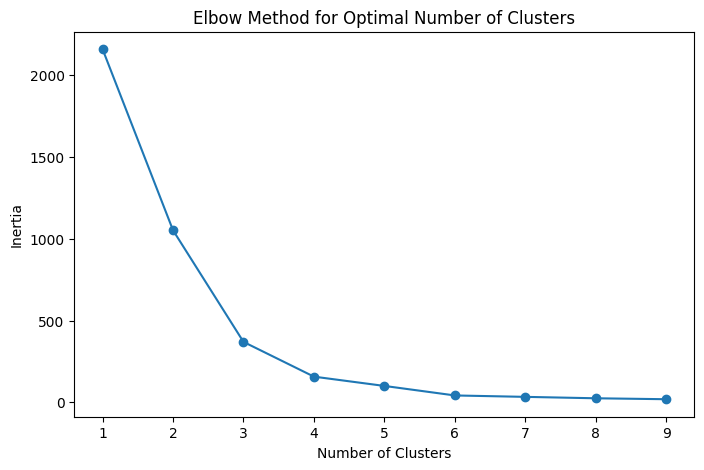

Cluster Assignments:
   price_per_10cl  premium  cluster
0            1.59        0        2
1            1.69        1        1
2            1.46        1        1
3            3.21        0        0
4            2.60        0        0
Cluster Summary:
         price_per_10cl  premium
cluster                         
0              3.188333      0.0
1              1.362500      1.0
2              1.303529      0.0


In [112]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# Select relevant features for clustering
features = wine_data[['price_per_10cl', 'premium']]  # Use only relevant features for clustering

# Normalize the features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Determine the optimal number of clusters using the elbow method
inertia = []
range_clusters = range(1, 10)  # Test cluster counts from 1 to 9
for k in range_clusters:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(features_scaled)
    inertia.append(kmeans.inertia_)

# Plot the elbow curve
plt.figure(figsize=(8, 5))
plt.plot(range_clusters, inertia, marker='o')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()

# Choose the optimal number of clusters (based on the elbow curve)
optimal_k = 3  # Replace this with the elbow point from the plot
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
wine_data['cluster'] = kmeans.fit_predict(features_scaled)  # Assign clusters to the wine data

# Preview the cluster assignments
print("Cluster Assignments:")
print(wine_data[['price_per_10cl', 'premium', 'cluster']].head())

# Optional: Analyze the clusters
cluster_summary = wine_data.groupby('cluster')[['price_per_10cl', 'premium']].mean()
print("Cluster Summary:")
print(cluster_summary)


# Define Food Pairing Rules

In [113]:
from sklearn.cluster import KMeans

# Perform K-Means clustering
optimal_k = 3  # Assuming 3 clusters based on the elbow method
kmeans = KMeans(n_clusters=optimal_k, random_state=42)

# Ensure features are properly scaled
wine_data['cluster'] = kmeans.fit_predict(features_scaled)

# Verify the cluster column is added
print("Cluster Assignments:")
print(wine_data['cluster'].head())

# Calculate cluster summary to identify patterns in the data
cluster_summary = wine_data.groupby('cluster')[['price_per_10cl', 'premium']].mean()

# Print the cluster summary for debugging and understanding
print("Cluster Summary:")
print(cluster_summary)

# Define food pairing rules dynamically based on cluster characteristics
food_pairings = {}
for cluster_id, row in cluster_summary.iterrows():
    if row['price_per_10cl'] > 2.0:  # Higher price wines
        if row['premium'] > 0.5:  # Premium wines
            food_pairings[cluster_id] = "Luxury Dishes (e.g., Truffles, Foie Gras)"
        else:
            food_pairings[cluster_id] = "Steak or Red Meat"
    else:  # Lower price wines
        if row['premium'] > 0.5:
            food_pairings[cluster_id] = "Fine Dining (e.g., Gourmet Pasta)"
        else:
            food_pairings[cluster_id] = "Casual Meals (e.g., Pizza, Pasta)"

# Check if the cluster column exists
if 'cluster' not in wine_data.columns:
    raise KeyError("Cluster column not found. Run the clustering step first.")

# Ensure all clusters have a defined pairing
undefined_clusters = set(wine_data['cluster'].unique()) - set(food_pairings.keys())
if undefined_clusters:
    print(f"Warning: No food pairing defined for clusters: {undefined_clusters}")

# Map food pairings to the cluster column
wine_data['food_pairing'] = wine_data['cluster'].map(food_pairings)

# Verify the food pairing column
print("Food Pairings for Clusters:")
print(wine_data[['cluster', 'food_pairing']].head())


Cluster Assignments:
0    2
1    1
2    1
3    0
4    0
Name: cluster, dtype: int32
Cluster Summary:
         price_per_10cl  premium
cluster                         
0              3.188333      0.0
1              1.362500      1.0
2              1.303529      0.0
Food Pairings for Clusters:
   cluster                       food_pairing
0        2  Casual Meals (e.g., Pizza, Pasta)
1        1  Fine Dining (e.g., Gourmet Pasta)
2        1  Fine Dining (e.g., Gourmet Pasta)
3        0                  Steak or Red Meat
4        0                  Steak or Red Meat


# Visualize the Clusters

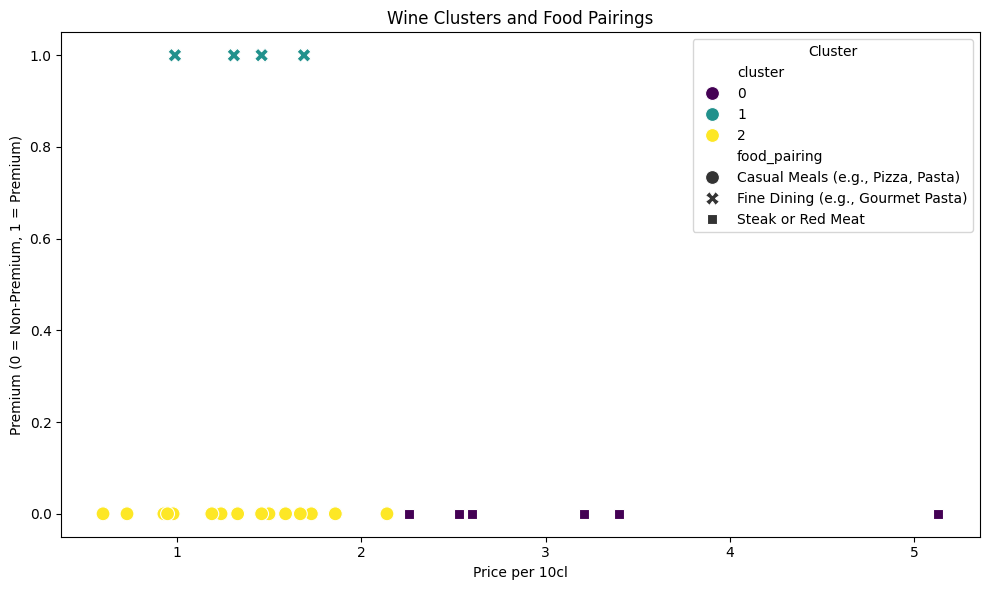

In [114]:
# Plot clusters based on price_per_10cl and premium
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=wine_data, 
    x='price_per_10cl', 
    y='premium', 
    hue='cluster', 
    palette='viridis', 
    style='food_pairing',
    s=100  # Adjust marker size for better visibility
)
plt.title('Wine Clusters and Food Pairings')
plt.xlabel('Price per 10cl')
plt.ylabel('Premium (0 = Non-Premium, 1 = Premium)')
plt.legend(title='Cluster')
plt.tight_layout()
plt.show()


# Recommendation Function

In [119]:
def recommend_food(wine_attributes, kmeans_model, scaler, food_pairings):
    """
    Recommend a food pairing based on wine attributes.

    Parameters:
    - wine_attributes: A dictionary with wine features (e.g., price_per_10cl, premium).
    - kmeans_model: Trained K-Means model.
    - scaler: Trained StandardScaler for data normalization.
    - food_pairings: Dictionary mapping clusters to food pairings.

    Returns:
    - Recommended food pairing.
    """
    # Prepare the input data
    features = pd.DataFrame([wine_attributes])
    features_scaled = scaler.transform(features)

    # Predict the cluster
    cluster = kmeans_model.predict(features_scaled)[0]

    # Return the food pairing
    return food_pairings.get(cluster, "No pairing found")


# Example usage
example_wine = {
    'price_per_10cl': 1,  # Example price
    'premium': 0          # Example premium status (1 = premium, 0 = non-premium)
}

pairing = recommend_food(example_wine, kmeans, scaler, food_pairings)
print(f"Recommended Food Pairing: {pairing}")


Recommended Food Pairing: Casual Meals (e.g., Pizza, Pasta)
